<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle 
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  
  
### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [0]:
#########importing libraries 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx  ###for graph technique 
import pdb
import pickle

In [2]:

traincsv = pd.read_csv('../train.csv')
print(traincsv[traincsv.isna().any(1)])
print(traincsv.info())
print("Number of duplicate entries: ",sum(traincsv.duplicated()))
traincsv.to_csv('../train_woheader.csv',header=False,index=False)
print("saved the graph into file")
#making graph 
g=nx.read_edgelist('../train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB
None
Number of duplicate entries:  0
saved the graph into file
Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


**Display the Graph**

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


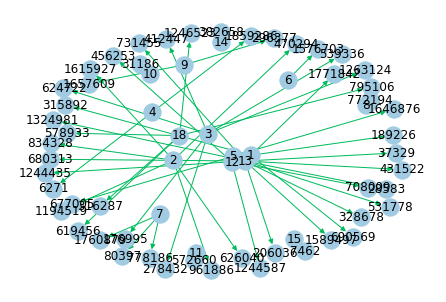

In [3]:
sample=pd.read_csv('../train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
#plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# **Exploratory Analysis**

In [4]:
print("Number of unique person",len(g.nodes()))

Number of unique person 1862220


**ON followers**

1862220
552


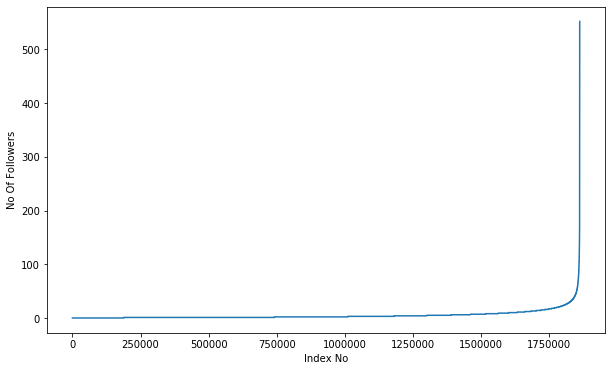

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
print(len(g.in_degree()))
print(max(indegree_dist))
indegree_dist.sort()

plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

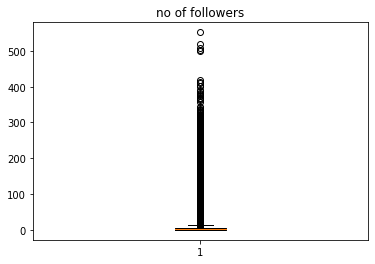

In [6]:
plt.boxplot(indegree_dist)
plt.title("no of followers")
plt.show()

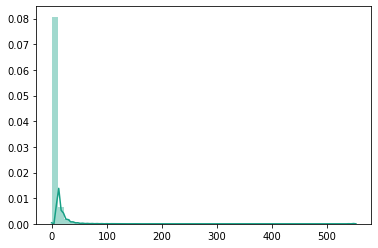

In [7]:
sns.distplot(indegree_dist, color='#16A085')

**On Following**

1862220
1566


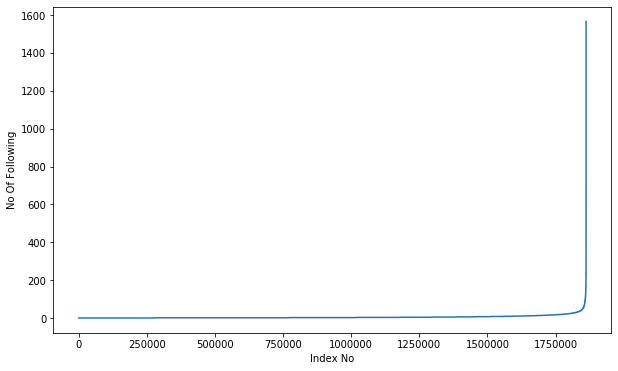

In [8]:
outdegree_dist = list(dict(g.out_degree()).values())
print(len(g.out_degree()))
print(max(outdegree_dist))
outdegree_dist.sort()

plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Following')
plt.show()

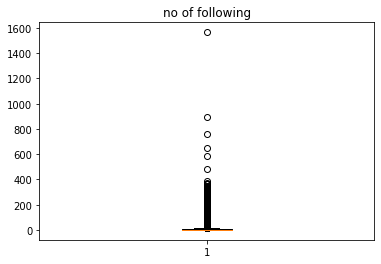

In [9]:
plt.boxplot(outdegree_dist)
plt.title("no of following")
plt.show()

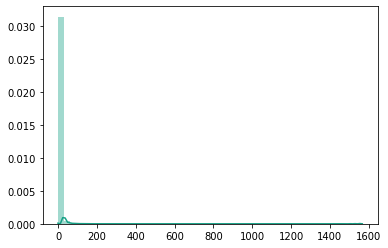

In [10]:
sns.distplot(outdegree_dist, color='#16A085')

**NO of following + followers**

In [0]:
from collections import Counter
dict_in = list(dict(g.in_degree()).values())
dict_out = list(dict(g.out_degree()).values())
#print(len(dict_in))


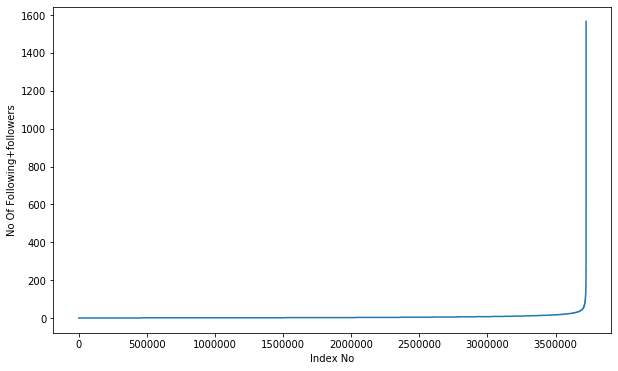

In [12]:
inoutdegree=list(dict_in+dict_out)
inoutdegree.sort()

plt.figure(figsize=(10,6))
plt.plot(inoutdegree)
plt.xlabel('Index No')
plt.ylabel('No Of Following+followers')
plt.show()

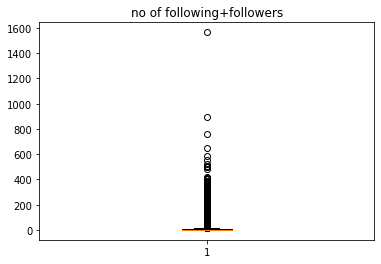

In [13]:
plt.boxplot(inoutdegree)
plt.title("no of following+followers")
plt.show()

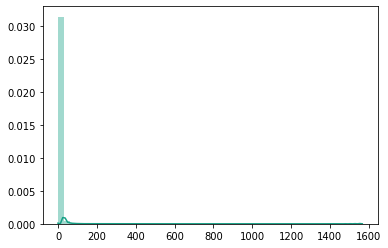

In [14]:
sns.distplot(inoutdegree,color='#16A085')

**Creating dataset for nodes having no edges between them.**
for balanced data:9437519 x 2 size


In [15]:
import random
r = csv.reader(open('../train_woheader.csv','r'))
edges = dict()
for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
missing_edges = set([])
while (len(missing_edges)<94375):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue

print(len(missing_edges))


94375


# **Test and training splitting** 80:20

In [16]:
from sklearn.model_selection import train_test_split
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
df_pos = pd.read_csv('../train.csv')
print(df_neg.head())
print(df_pos.head())
print(df_neg.shape)
print(df_pos.shape)
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
X_train_pos.to_csv('../train_pos_after_eda.csv',header=False, index=False)
X_test_pos.to_csv('../test_pos_after_eda.csv',header=False, index=False)
X_train_neg.to_csv('../train_neg_after_eda.csv',header=False, index=False)
X_test_neg.to_csv('../test_neg_after_eda.csv',header=False, index=False)


X_train_pos = pd.read_csv('../train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv('../test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv('../train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv('../test_neg_after_eda.csv', names=['source_node', 'destination_node'])

##concatinating x trian pos+ x trian neg ,  y_train pos+y_test_neg
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 


#####
X_train.to_csv('../train_after_eda.csv',header=False,index=False)
X_test.to_csv('../test_after_eda.csv',header=False,index=False)
#final dataset
pd.DataFrame(y_train.astype(int)).to_csv('../train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('../test_y.csv',header=False,index=False)

   source_node  destination_node
0       387031           1570803
1      1345924           1784412
2       674781             98930
3       780372           1650424
4       558073           1310406
   source_node  destination_node
0            1            690569
1            1            315892
2            1            189226
3            2            834328
4            2           1615927
(94375, 2)
(9437519, 2)
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 75500 = 75500
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 18875 = 18875


In [17]:
train_graph=nx.read_edgelist('../train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# **Featurization start**

# **Jaccard INdex**
\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [0]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

# **Cosine Distance**
\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [0]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

# **Shortest path**

In [0]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

# **Adamic/Adar Index**

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [0]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

# **IS Person follow Back**

In [0]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [24]:
df_final_train = pd.read_csv('../train_after_eda.csv', names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('../train_y.csv', names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

#test 
df_final_test = pd.read_csv('../test_after_eda.csv', names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('../test_y.csv', names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our train matrix size  (7625515, 3)
Our test matrix size  (1906379, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1248963,444518,1


# **Adding all features**
## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>

<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
</ol>



In [25]:
from tqdm import tqdm
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:15<00:00, 117544.64it/s]


In [28]:
print(df_final_test.shape)
print(df_final_train.shape)

(1906379, 6)
(7625515, 6)


In [0]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train[0:94375].apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test[0:24361].apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train[:94375].apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test[0:24361].apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train[:94375].apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test[0:24361].apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

                                          
    df_final_train['adar_index'] = df_final_train[:94375].apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test[0:24361].apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train[:94375].apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test[0:24361].apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
    df_final_train['shortest_path'] = df_final_train[:94375].apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test[0:24361].apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    df_final_train['weight_in'] = df_final_train[:94375].destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train[:94375].source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test[0:24361].destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test[0:24361].source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train[:94375].weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train[:94375].weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train[:94375].weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train[:94375].weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test[0:24361].weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test[0:24361].weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test[0:24361].weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test[0:24361].weight_in + 2*df_final_test.weight_out)

# **NOw it's time to applying a Model**


In [33]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)


AttributeError: ignored

# **Random Forest**

In [0]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [0]:

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print(rf_random.best_estimator_)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

Train confusion_matrix


NameError: ignored

In [0]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

NameError: ignored

# **features importance**

In [0]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()